In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from snowpylot import caaml_parser

parse_pits function: Parses all pits in a specified folder

In [4]:
def parse_pits(folder_path):
    """
    Function to parse CAAML files in the specified folder
    """

    files = [
        f for f in os.listdir(folder_path) if f.endswith(".xml")
    ]  # List of all .xml files in the folder

    pits_list = []

    for file in files:  # iterate through each file in the folder
        file_path = folder_path + "/" + file  # create the file path
        pit = caaml_parser(file_path)  # parse the file
        pits_list.append(pit)

    return pits_list

Specify folders for 2020-2024 Water Years and parse files

In [5]:
# Define folders and parse pits

pits_19_20 = parse_pits("../snowpits/by_season/2019-2020")
pits_20_21 = parse_pits("../snowpits/by_season/2020-2021")
pits_21_22 = parse_pits("../snowpits/by_season/2021-2022")
pits_22_23 = parse_pits("../snowpits/by_season/2022-2023")
pits_23_24 = parse_pits("../snowpits/by_season/2023-2024")

all_pits = (
    pits_19_20 + pits_20_21 + pits_21_22 + pits_22_23 + pits_23_24
)  # list of all pits

Find pits where "pit_near_avalanche" is true

In [12]:
pits_near_avalanche = []

for pit in all_pits:
    if pit.core_info.location.pit_near_avalanche:
        pits_near_avalanche.append(pit)

print(len(pits_near_avalanche))



945


Get info about pits near avalanches

In [15]:
pit_info_list = []

for pit in pits_near_avalanche:
    num_primary_grain_form = 0  # initialize
    num_primary_grain_size = 0  # initialize
    for layer in pit.snow_profile.layers:  # iterate through each layer in the pit
        if layer.grain_form_primary is not None:  # if the layer has a primary grain form
            num_primary_grain_form += 1  # increment the number of primary grain forms
            if (
                layer.grain_form_primary.grain_size_avg is not None
            ):  # if the layer has a primary grain size
                num_primary_grain_size += 1  # increment the number of primary grain sizes

    pit_info_dict = {
        # Metadata
        "PitID": pit.core_info.pit_id,
        "Date": pit.core_info.date,
        # User
        "SnowPilot Username": pit.core_info.user.username,
        "Professional": pit.core_info.user.professional,
        "Operation Name": pit.core_info.user.operation_name,
        # Location
        "Latitude": pit.core_info.location.latitude,
        "Longitude": pit.core_info.location.longitude,
        "Elevation": pit.core_info.location.elevation,
        "Aspect": pit.core_info.location.aspect,
        "Slope Angle": pit.core_info.location.slope_angle,
        "Country": pit.core_info.location.country,
        "Region": pit.core_info.location.region,
        "Pit Near Avalanche Location": pit.core_info.location.pit_near_avalanche_location,
        # Snow Profile
        "HS": pit.snow_profile.hs,
        # Layers
        "Num Layers": len(pit.snow_profile.layers),
        "num Layers wPrimary Grain Form": num_primary_grain_form,
        "num Layers wPrimary Grain Size": num_primary_grain_size,
        # Stability Tests
        "Num ECT": len(pit.stability_tests.ECT),
        "Num CT": len(pit.stability_tests.CT),
        "Num RBlock": len(pit.stability_tests.RBlock),
        "Num PST": len(pit.stability_tests.PST),
    }
    pit_info_list.append(pit_info_dict)

    pit_info_df = pd.DataFrame(pit_info_list)


Summary Stats and info for Pits Near Avalanches

In [20]:
# Summary statistics for pit_info_df 
print("=== SNOW PITS NEAR AVALANCHE LOCATIONS SUMMARY ===\n")

# Helper function to extract numeric values from [value, unit] lists
def extract_numeric_value(data_series):
    """Extract numeric values from lists of format [value, unit]"""
    numeric_values = []
    for item in data_series:
        if item is not None and isinstance(item, list) and len(item) >= 1:
            try:
                numeric_values.append(float(item[0]))
            except (ValueError, TypeError):
                continue
        elif item is not None:
            try:
                numeric_values.append(float(item))
            except (ValueError, TypeError):
                continue
    return pd.Series(numeric_values)

# Basic dataset info
print(f"Total number of pits: {len(pit_info_df)}")

# Handle dates safely
try:
    date_min = pit_info_df['Date'].min()
    date_max = pit_info_df['Date'].max()
    print(f"Date range: {date_min} to {date_max}")
except:
    print("Date range: Unable to determine (mixed data types)")
print()

# Geographic distribution
print("=== GEOGRAPHIC DISTRIBUTION ===")
try:
    print(f"Countries represented: {pit_info_df['Country'].nunique()}")
    print(f"Regions represented: {pit_info_df['Region'].nunique()}")
    print(f"Top 5 regions by pit count:")
    print(pit_info_df['Region'].value_counts().head())
except Exception as e:
    print(f"Geographic data: Unable to process ({str(e)})")
print()

# Elevation and terrain - extract numeric values from lists
print("=== ELEVATION AND TERRAIN ===")
try:
    elevation_clean = extract_numeric_value(pit_info_df['Elevation'])
    
    if len(elevation_clean) > 0:
        print(f"Elevation range: {elevation_clean.min():.0f}m to {elevation_clean.max():.0f}m")
        print(f"Mean elevation: {elevation_clean.mean():.0f}m")
        print(f"Median elevation: {elevation_clean.median():.0f}m")
        print(f"Valid elevation data: {len(elevation_clean)}/{len(pit_info_df)} pits ({len(elevation_clean)/len(pit_info_df)*100:.1f}%)")
    else:
        print("No valid elevation data found")
except Exception as e:
    print(f"Elevation data: Unable to process ({str(e)})")

try:
    slope_clean = extract_numeric_value(pit_info_df['Slope Angle'])
    
    if len(slope_clean) > 0:
        print(f"Slope angle range: {slope_clean.min():.0f}° to {slope_clean.max():.0f}°")
        print(f"Mean slope angle: {slope_clean.mean():.1f}°")
        print(f"Valid slope angle data: {len(slope_clean)}/{len(pit_info_df)} pits ({len(slope_clean)/len(pit_info_df)*100:.1f}%)")
    else:
        print("No valid slope angle data found")
except Exception as e:
    print(f"Slope angle data: Unable to process ({str(e)})")
print()

# Aspect distribution
print("=== ASPECT DISTRIBUTION ===")
try:
    aspect_counts = pit_info_df['Aspect'].value_counts()
    print(aspect_counts)
except Exception as e:
    print(f"Aspect data: Unable to process ({str(e)})")
print()

# Snow depth (HS) - extract numeric values from lists
print("=== SNOW DEPTH (HS) ===")
try:
    hs_clean = extract_numeric_value(pit_info_df['HS'])
    
    if len(hs_clean) > 0:
        print(f"Snow depth range: {hs_clean.min():.0f}cm to {hs_clean.max():.0f}cm")
        print(f"Mean snow depth: {hs_clean.mean():.1f}cm")
        print(f"Median snow depth: {hs_clean.median():.1f}cm")
        print(f"Valid HS data: {len(hs_clean)}/{len(pit_info_df)} pits ({len(hs_clean)/len(pit_info_df)*100:.1f}%)")
    else:
        print("No valid snow depth data found")
except Exception as e:
    print(f"Snow depth data: Unable to process ({str(e)})")
print()

# Layer information
print("=== LAYER INFORMATION ===")
try:
    layers_numeric = pd.to_numeric(pit_info_df['Num Layers'], errors='coerce')
    layers_clean = layers_numeric.dropna()
    
    if len(layers_clean) > 0:
        print(f"Average number of layers per pit: {layers_clean.mean():.1f}")
        print(f"Range of layers: {layers_clean.min():.0f} to {layers_clean.max():.0f}")
    
    # Grain form and size data
    grain_form_numeric = pd.to_numeric(pit_info_df['num Layers wPrimary Grain Form'], errors='coerce')
    grain_size_numeric = pd.to_numeric(pit_info_df['num Layers wPrimary Grain Size'], errors='coerce')
    
    pits_with_grain_form = (grain_form_numeric > 0).sum()
    pits_with_grain_size = (grain_size_numeric > 0).sum()
    
    print(f"Pits with primary grain form data: {pits_with_grain_form} ({pits_with_grain_form/len(pit_info_df)*100:.1f}%)")
    print(f"Pits with primary grain size data: {pits_with_grain_size} ({pits_with_grain_size/len(pit_info_df)*100:.1f}%)")
except Exception as e:
    print(f"Layer data: Unable to process ({str(e)})")
print()

# Stability tests
print("=== STABILITY TESTS ===")
try:
    ect_numeric = pd.to_numeric(pit_info_df['Num ECT'], errors='coerce')
    ct_numeric = pd.to_numeric(pit_info_df['Num CT'], errors='coerce')
    rblock_numeric = pd.to_numeric(pit_info_df['Num RBlock'], errors='coerce')
    pst_numeric = pd.to_numeric(pit_info_df['Num PST'], errors='coerce')
    
    pits_with_ect = (ect_numeric > 0).sum()
    pits_with_ct = (ct_numeric > 0).sum()
    pits_with_rblock = (rblock_numeric > 0).sum()
    pits_with_pst = (pst_numeric > 0).sum()
    
    print(f"Pits with ECT tests: {pits_with_ect} ({pits_with_ect/len(pit_info_df)*100:.1f}%)")
    print(f"Pits with CT tests: {pits_with_ct} ({pits_with_ct/len(pit_info_df)*100:.1f}%)")
    print(f"Pits with RBlock tests: {pits_with_rblock} ({pits_with_rblock/len(pit_info_df)*100:.1f}%)")
    print(f"Pits with PST tests: {pits_with_pst} ({pits_with_pst/len(pit_info_df)*100:.1f}%)")
except Exception as e:
    print(f"Stability test data: Unable to process ({str(e)})")
print()

# User information
print("=== USER INFORMATION ===")
try:
    print(f"Unique users: {pit_info_df['SnowPilot Username'].nunique()}")
    
    # Handle professional status
    professional_data = pit_info_df['Professional']
    professional_count = professional_data.sum()
    print(f"Professional users: {professional_count} ({professional_count/len(pit_info_df)*100:.1f}%)")
    
    print(f"Unique operations: {pit_info_df['Operation Name'].nunique()}")
except Exception as e:
    print(f"User data: Unable to process ({str(e)})")
print()

# Pit near avalanche location breakdown
print("=== PIT LOCATION RELATIVE TO AVALANCHE ===")
try:
    location_counts = pit_info_df['Pit Near Avalanche Location'].value_counts()
    print(location_counts)
    print()
    
    # Calculate percentages
    location_percentages = (location_counts / len(pit_info_df) * 100).round(1)
    print("Percentages:")
    for location, percentage in location_percentages.items():
        print(f"{location}: {percentage}%")
except Exception as e:
    print(f"Avalanche location data: Unable to process ({str(e)})")
print()

# Data completeness
print("=== DATA COMPLETENESS ===")
try:
    missing_data = pit_info_df.isnull().sum()
    missing_percent = (missing_data / len(pit_info_df)) * 100
    completeness_df = pd.DataFrame({
        'Missing Count': missing_data,
        'Missing %': missing_percent.round(1)
    }).sort_values('Missing %', ascending=False)
    
    # Only show columns with missing data
    incomplete_data = completeness_df[completeness_df['Missing Count'] > 0]
    if len(incomplete_data) > 0:
        print(incomplete_data)
    else:
        print("No missing data found!")
except Exception as e:
    print(f"Data completeness analysis: Unable to process ({str(e)})")

# Additional elevation and slope statistics
print("\n=== ADDITIONAL TERRAIN STATISTICS ===")
try:
    elevation_clean = extract_numeric_value(pit_info_df['Elevation'])
    slope_clean = extract_numeric_value(pit_info_df['Slope Angle'])
    
    if len(elevation_clean) > 0:
        print("Elevation distribution:")
        print(f"  25th percentile: {elevation_clean.quantile(0.25):.0f}m")
        print(f"  75th percentile: {elevation_clean.quantile(0.75):.0f}m")
        print(f"  Standard deviation: {elevation_clean.std():.0f}m")
    
    if len(slope_clean) > 0:
        print("Slope angle distribution:")
        print(f"  25th percentile: {slope_clean.quantile(0.25):.0f}°")
        print(f"  75th percentile: {slope_clean.quantile(0.75):.0f}°")
        print(f"  Standard deviation: {slope_clean.std():.1f}°")
        
        # Slope angle categories
        print("Slope angle categories:")
        gentle = (slope_clean < 30).sum()
        moderate = ((slope_clean >= 30) & (slope_clean < 35)).sum()
        steep = ((slope_clean >= 35) & (slope_clean < 40)).sum()
        very_steep = (slope_clean >= 40).sum()
        
        print(f"  Gentle (<30°): {gentle} ({gentle/len(slope_clean)*100:.1f}%)")
        print(f"  Moderate (30-34°): {moderate} ({moderate/len(slope_clean)*100:.1f}%)")
        print(f"  Steep (35-39°): {steep} ({steep/len(slope_clean)*100:.1f}%)")
        print(f"  Very steep (≥40°): {very_steep} ({very_steep/len(slope_clean)*100:.1f}%)")
        
except Exception as e:
    print(f"Additional terrain statistics: Unable to process ({str(e)})")

=== SNOW PITS NEAR AVALANCHE LOCATIONS SUMMARY ===

Total number of pits: 945
Date range: 2017-12-05 to 2024-09-20

=== GEOGRAPHIC DISTRIBUTION ===
Countries represented: 18
Regions represented: 84
Top 5 regions by pit count:
Region
CO               165
BC               114
MT                82
Wasatch Range     62
AK                59
Name: count, dtype: int64

=== ELEVATION AND TERRAIN ===
Elevation range: 243m to 5000m
Mean elevation: 2351m
Median elevation: 2500m
Valid elevation data: 937/945 pits (99.2%)
Slope angle range: 5° to 49°
Mean slope angle: 31.8°
Valid slope angle data: 880/945 pits (93.1%)

=== ASPECT DISTRIBUTION ===
Aspect
NE    205
E     187
N     132
SE    119
NW     78
S      74
W      63
SW     42
Name: count, dtype: int64

=== SNOW DEPTH (HS) ===
Snow depth range: 12cm to 1456cm
Mean snow depth: 163.6cm
Median snow depth: 137.0cm
Valid HS data: 900/945 pits (95.2%)

=== LAYER INFORMATION ===
Average number of layers per pit: 7.4
Range of layers: 0 to 19
Pits with

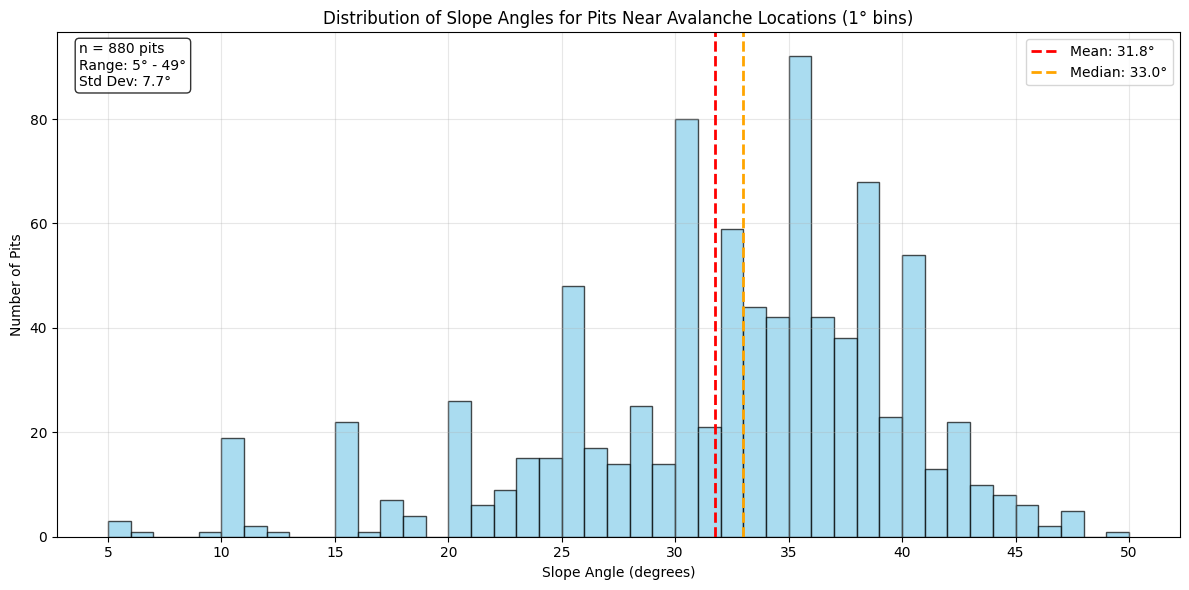

Slope Angle Distribution Summary:
Total pits with slope data: 880
Mean slope angle: 31.8°
Median slope angle: 33.0°
Standard deviation: 7.7°
Range: 5° to 49°


In [25]:
# Extract numeric slope angle values using your existing helper function
slope_clean = extract_numeric_value(pit_info_df['Slope Angle'])

# Create bins with 1-degree intervals
min_slope = int(slope_clean.min())
max_slope = int(slope_clean.max()) + 1
bins = np.arange(min_slope, max_slope + 1, 1)  # 1-degree buckets

# Create the histogram
plt.figure(figsize=(12, 6))
plt.hist(slope_clean, bins=bins, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Slope Angle (degrees)')
plt.ylabel('Number of Pits')
plt.title('Distribution of Slope Angles for Pits Near Avalanche Locations (1° bins)')
plt.grid(True, alpha=0.3)

# Add some statistics to the plot
mean_slope = slope_clean.mean()
median_slope = slope_clean.median()
plt.axvline(mean_slope, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_slope:.1f}°')
plt.axvline(median_slope, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_slope:.1f}°')

# Add legend
plt.legend()

# Show statistics
plt.text(0.02, 0.98, f'n = {len(slope_clean)} pits\nRange: {slope_clean.min():.0f}° - {slope_clean.max():.0f}°\nStd Dev: {slope_clean.std():.1f}°', 
         transform=plt.gca().transAxes, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Set x-axis to show every 5 degrees for better readability
plt.xticks(np.arange(min_slope, max_slope + 1, 5))

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Slope Angle Distribution Summary:")
print(f"Total pits with slope data: {len(slope_clean)}")
print(f"Mean slope angle: {slope_clean.mean():.1f}°")
print(f"Median slope angle: {slope_clean.median():.1f}°")
print(f"Standard deviation: {slope_clean.std():.1f}°")
print(f"Range: {slope_clean.min():.0f}° to {slope_clean.max():.0f}°")

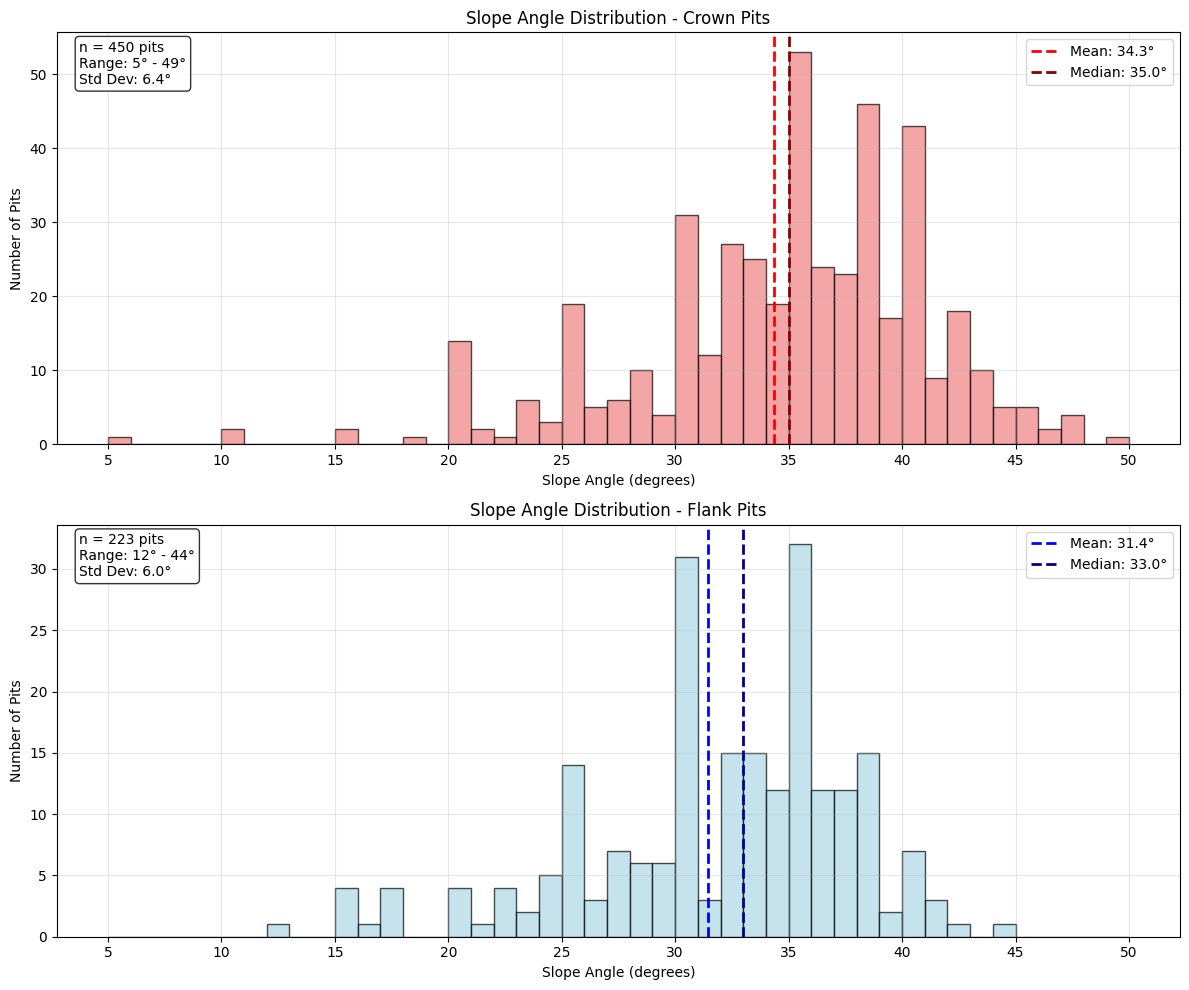

=== SLOPE ANGLE COMPARISON: CROWN vs FLANK PITS ===

CROWN PITS:
  Total pits with slope data: 450
  Mean slope angle: 34.3°
  Median slope angle: 35.0°
  Standard deviation: 6.4°
  Range: 5° to 49°

FLANK PITS:
  Total pits with slope data: 223
  Mean slope angle: 31.4°
  Median slope angle: 33.0°
  Standard deviation: 6.0°
  Range: 12° to 44°

DIFFERENCE (Crown - Flank):
  Mean difference: 2.9°
  Median difference: 2.0°


In [26]:
# Extract numeric slope angle values using your existing helper function
slope_clean = extract_numeric_value(pit_info_df['Slope Angle'])

# Filter data for crown and flank locations
crown_mask = pit_info_df['Pit Near Avalanche Location'] == 'crown'
flank_mask = pit_info_df['Pit Near Avalanche Location'] == 'flank'

# Get slope angles for crown and flank pits
crown_slopes = extract_numeric_value(pit_info_df[crown_mask]['Slope Angle'])
flank_slopes = extract_numeric_value(pit_info_df[flank_mask]['Slope Angle'])

# Create bins with 1-degree intervals (using overall range)
min_slope = int(slope_clean.min())
max_slope = int(slope_clean.max()) + 1
bins = np.arange(min_slope, max_slope + 1, 1)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Crown pits histogram
ax1.hist(crown_slopes, bins=bins, edgecolor='black', alpha=0.7, color='lightcoral')
ax1.set_xlabel('Slope Angle (degrees)')
ax1.set_ylabel('Number of Pits')
ax1.set_title('Slope Angle Distribution - Crown Pits')
ax1.grid(True, alpha=0.3)

# Add statistics for crown pits
crown_mean = crown_slopes.mean()
crown_median = crown_slopes.median()
ax1.axvline(crown_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {crown_mean:.1f}°')
ax1.axvline(crown_median, color='darkred', linestyle='--', linewidth=2, label=f'Median: {crown_median:.1f}°')
ax1.legend()

# Add statistics text box for crown
ax1.text(0.02, 0.98, f'n = {len(crown_slopes)} pits\nRange: {crown_slopes.min():.0f}° - {crown_slopes.max():.0f}°\nStd Dev: {crown_slopes.std():.1f}°', 
         transform=ax1.transAxes, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Set x-axis ticks
ax1.set_xticks(np.arange(min_slope, max_slope + 1, 5))

# Flank pits histogram
ax2.hist(flank_slopes, bins=bins, edgecolor='black', alpha=0.7, color='lightblue')
ax2.set_xlabel('Slope Angle (degrees)')
ax2.set_ylabel('Number of Pits')
ax2.set_title('Slope Angle Distribution - Flank Pits')
ax2.grid(True, alpha=0.3)

# Add statistics for flank pits
flank_mean = flank_slopes.mean()
flank_median = flank_slopes.median()
ax2.axvline(flank_mean, color='blue', linestyle='--', linewidth=2, label=f'Mean: {flank_mean:.1f}°')
ax2.axvline(flank_median, color='darkblue', linestyle='--', linewidth=2, label=f'Median: {flank_median:.1f}°')
ax2.legend()

# Add statistics text box for flank
ax2.text(0.02, 0.98, f'n = {len(flank_slopes)} pits\nRange: {flank_slopes.min():.0f}° - {flank_slopes.max():.0f}°\nStd Dev: {flank_slopes.std():.1f}°', 
         transform=ax2.transAxes, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Set x-axis ticks
ax2.set_xticks(np.arange(min_slope, max_slope + 1, 5))

plt.tight_layout()
plt.show()

# Print comparison statistics
print("=== SLOPE ANGLE COMPARISON: CROWN vs FLANK PITS ===\n")

print("CROWN PITS:")
print(f"  Total pits with slope data: {len(crown_slopes)}")
print(f"  Mean slope angle: {crown_mean:.1f}°")
print(f"  Median slope angle: {crown_median:.1f}°")
print(f"  Standard deviation: {crown_slopes.std():.1f}°")
print(f"  Range: {crown_slopes.min():.0f}° to {crown_slopes.max():.0f}°")

print("\nFLANK PITS:")
print(f"  Total pits with slope data: {len(flank_slopes)}")
print(f"  Mean slope angle: {flank_mean:.1f}°")
print(f"  Median slope angle: {flank_median:.1f}°")
print(f"  Standard deviation: {flank_slopes.std():.1f}°")
print(f"  Range: {flank_slopes.min():.0f}° to {flank_slopes.max():.0f}°")

print(f"\nDIFFERENCE (Crown - Flank):")
print(f"  Mean difference: {crown_mean - flank_mean:.1f}°")
print(f"  Median difference: {crown_median - flank_median:.1f}°")